# DonkeyCar RL - SAC Algorithm

## Summary
This notebook trains an Soft Actor-Critic RL-Agent for the donkeycar environment. The agent learns to map a dimension reduced input of the environment to a continous action space with two items: one float for the speed and one for the steering.

## Sources
The notebook is based on the SAC training from chapter 12 of the lecture notes.

In [4]:
# check GPU setup
!nvidia-smi

Sun Jul 30 15:41:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 527.41       Driver Version: 527.41       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:58:00.0 Off |                  N/A |
| N/A   76C    P0    N/A /  N/A |    266MiB /  2048MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set environment variables
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['OMP_NUM_THREADS'] = '1'

# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torch.distributions import Normal

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from itertools import count

import subprocess
import os.path
import tempfile
import random
import base64
import glob
import time
import json
import gym
import io
import os
import gc

from gym import wrappers
import gym_donkeycar
from typing import Tuple, Callable, Any, Optional, List, Union
import sys

sys.path.append(os.path.join(os.path.dirname("__file__"), "./train_ae_template/"))
from ae.autoencoder import load_ae

# Define some constants
LEAVE_PRINT_EVERY_N_SECS = 100
ERASE_LINE = '\x1b[2K'
EPS = 1e-6
BEEP = lambda: os.system("printf '\a'")
RESULTS_DIR = os.path.join('..', 'results')
# SEEDS are ignored first due to training time
# SEEDS = (12, 34, 56, 78, 90)

# Enable displaying Matplotlib plots in Jupyter Notebook
%matplotlib inline

In [6]:
# Set the 'fivethirtyeight' style for the plots
plt.style.use('fivethirtyeight')

# Set custom plot parameters for better visualization
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)

# Suppress scientific notation when printing arrays
np.set_printoptions(suppress=True)

In [7]:
#Check if CUDA is available
torch.cuda.is_available()

True

In [8]:
def get_make_env_fn(**kargs: Any) -> Tuple[Callable[..., gym.Env], dict]:
    """
    Get the make_env_fn function along with keyword arguments.

    Returns:
        Tuple[Callable[..., gym.Env], dict]: A tuple containing the make_env_fn function and keyword arguments.
    """

    def make_env_fn(
        env_name: str = "donkey-generated-track-v0",
        seed: Optional[int] = None,
        render: Optional[bool] = None,
        record: bool = False,
        unwrapped: bool = False,
        monitor_mode: Optional[int] = None,
        inner_wrappers: Optional[List[Callable[[gym.Env], gym.Env]]] = None,
        outer_wrappers: Optional[List[Callable[[gym.Env], gym.Env]]] = None,
    ) -> gym.Env:
        """
        Create and return a gym environment.

        Args:
            env_name (str, optional): The name of the gym environment. Defaults to "donkey-generated-track-v0".
            seed (int, optional): The random seed for the environment. Defaults to None.
            render (bool, optional): Whether to render the environment. Defaults to None.
            record (bool, optional): Whether to record the environment. Defaults to False.
            unwrapped (bool, optional): Whether to unwrap the environment. Defaults to False.
            monitor_mode (int, optional): The monitor mode for the environment. Defaults to None.
            inner_wrappers (List[Callable[[gym.Env], gym.Env]], optional): List of inner wrappers to apply to the environment. Defaults to None.
            outer_wrappers (List[Callable[[gym.Env], gym.Env]], optional): List of outer wrappers to apply to the environment. Defaults to None.

        Returns:
            gym.Env: The created gym environment.
        """

        mdir = tempfile.mkdtemp()
        env = None
        if render:
            try:
                train_conf = {
                    "exe_path": "C:/Users/Phili/Desktop/RL_Project/DonkeySimWin/donkey_sim.x86_64",
                    "host": "127.0.0.1",
                    "port": 9091,
                    "car_name": "training",
                    "max_cte": 4.0,
                }
                env = gym.make(env_name, conf=train_conf)
                # env = gym.make(env_name, render=render)
            except:
                pass
        if env is None:
            train_conf = {
                    "exe_path": "C:/Users/Phili/Desktop/RL_Project/DonkeySimWin/donkey_sim.x86_64",
                    "host": "127.0.0.1",
                    "port": 9091,
                    "car_name": "training",
                    "max_cte": 4.0,
                    "render": False
                }
            env = gym.make(env_name, conf=train_conf)
        if seed is not None:
            env.seed(seed)
        env = env.unwrapped if unwrapped else env
        if inner_wrappers:
            for wrapper in inner_wrappers:
                env = wrapper(env)
        env = wrappers.Monitor(
            env,
            mdir,
            force=True,
            mode=monitor_mode,
            video_callable=lambda e_idx: record
        ) if monitor_mode else env
        if outer_wrappers:
            for wrapper in outer_wrappers:
                env = wrapper(env)
        return env

    return make_env_fn, kargs


In [9]:
def get_videos_html(env_videos: List[Tuple[str, str]], title: str, max_n_videos: int = 4) -> Union[str, None]:
    """
    Generate HTML code to display videos with titles.

    Args:
        env_videos (List[Tuple[str, str]]): List of tuples containing video file paths and corresponding meta file paths.
        title (str): The title for the HTML section.
        max_n_videos (int, optional): The maximum number of videos to display. Defaults to 4.

    Returns:
        Union[str, None]: The HTML code as a string if videos are available, otherwise None.
    """

    videos = np.array(env_videos)

    if len(videos) == 0:
        return None

    n_videos = max(1, min(max_n_videos, len(videos)))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int) if n_videos > 1 else [-1,]
    videos = videos[idxs,...]

    strm = '<h2>{}</h2>'.format(title)
    for video_path, meta_path in videos:
        video = io.open(video_path, 'r+b').read()
        encoded = base64.b64encode(video)

        with open(meta_path) as data_file:
            meta = json.load(data_file)

        html_tag = """
        <h3>{}</h3>
        <video width="960" height="540" controls>
            <source src="data:video/mp4;base64,{}" type="video/mp4" />
        </video>"""
        strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))

    return strm

In [10]:
def get_gif_html(env_videos: List[Tuple[str, str]], title: str, subtitle_eps: Union[None, List[str]] = None, max_n_videos: int = 4) -> Union[str, None]:
    """
    Generate HTML code to display GIFs with titles.

    Args:
        env_videos (List[Tuple[str, str]]): List of tuples containing video file paths and corresponding meta file paths.
        title (str): The title for the HTML section.
        subtitle_eps (Union[None, List[str]], optional): List of subtitles for episodes. Defaults to None.
        max_n_videos (int, optional): The maximum number of videos to display. Defaults to 4.

    Returns:
        Union[str, None]: The HTML code as a string if videos are available, otherwise None.
    """

    videos = np.array(env_videos)

    if len(videos) == 0:
        return None

    n_videos = max(1, min(max_n_videos, len(videos)))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int) if n_videos > 1 else [-1,]
    videos = videos[idxs,...]

    strm = '<h2>{}</h2>'.format(title)
    for video_path, meta_path in videos:
        basename = os.path.splitext(video_path)[0]
        gif_path = basename + '.gif'
        if not os.path.exists(gif_path):
            ps = subprocess.Popen(
                ('ffmpeg', 
                 '-i', video_path, 
                 '-r', '7',
                 '-f', 'image2pipe', 
                 '-vcodec', 'ppm',
                 '-crf', '20',
                 '-vf', 'scale=512:-1',
                 '-'), 
                stdout=subprocess.PIPE)
            output = subprocess.check_output(
                ('convert',
                 '-coalesce',
                 '-delay', '7',
                 '-loop', '0',
                 '-fuzz', '2%',
                 '+dither',
                 '-deconstruct',
                 '-layers', 'Optimize',
                 '-', gif_path), 
                stdin=ps.stdout)
            ps.wait()

        gif = io.open(gif_path, 'r+b').read()
        encoded = base64.b64encode(gif)
            
        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h3>{0}<h3/>
        <img src="data:image/gif;base64,{1}" />"""
        prefix = 'Trial ' if subtitle_eps is None else 'Episode '
        suffix = str(meta['episode_id'] if subtitle_eps is None else subtitle_eps[meta['episode_id']])
        strm += html_tag.format(prefix + suffix, encoded.decode('ascii'))
    return strm


In [11]:
class RenderUint8(gym.Wrapper):
    """
    Gym environment wrapper to convert the rendered frames to uint8 format.

    Args:
        env (gym.Env): The original Gym environment.

    Attributes:
        env (gym.Env): The original Gym environment wrapped by this class.
    """

    def __init__(self, env: gym.Env):
        """
        Initialize the RenderUint8 wrapper.

        Args:
            env (gym.Env): The original Gym environment.
        """
        super().__init__(env)

    def reset(self, **kwargs) -> np.ndarray:
        """
        Reset the environment.

        Args:
            **kwargs: Additional arguments to be passed to the reset function.

        Returns:
            np.ndarray: The initial observation after resetting the environment.
        """
        return self.env.reset(**kwargs)

    def render(self, mode: str = 'rgb_array') -> np.ndarray:
        """
        Render the environment.

        Args:
            mode (str, optional): The rendering mode. Defaults to 'rgb_array'.

        Returns:
            np.ndarray: The rendered frame as a numpy array in uint8 format.
        """
        frame = self.env.render(mode=mode)
        return frame.astype(np.uint8)


# SAC


## FCQSA

In [12]:
class FCQSA(nn.Module):
    """
    Fully Connected Q-Value Network with State and Action inputs.

    Args:
        input_dim (int): The dimension of the input state.
        output_dim (int): The dimension of the output action.
        obs_space_size (int, optional): The size of the observation space. Defaults to 32.
        hidden_dims (Tuple[int, int], optional): A tuple of integers representing the sizes of hidden layers. Defaults to (32, 32).
        activation_fc (Callable, optional): The activation function to be used. Defaults to F.relu.

    Attributes:
        activation_fc (Callable): The activation function used in the network.
        input_layer (nn.Linear): The input layer of the network.
        hidden_layers (nn.ModuleList): A list of hidden layers in the network.
        output_layer (nn.Linear): The output layer of the network.
        device (torch.device): The device on which the network is stored.
    """

    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        hidden_dims: Tuple[int, int] = (32, 32),
        activation_fc: Callable = F.relu,
    ):
        """
        Initialize the FCQSA network.

        Args:
            input_dim (int): The dimension of the input state.
            output_dim (int): The dimension of the output action.
            obs_space_size (int, optional): The size of the observation space. Defaults to 32.
            hidden_dims (Tuple[int, int], optional): A tuple of integers representing the sizes of hidden layers. Defaults to (32, 32).
            activation_fc (Callable, optional): The activation function to be used. Defaults to F.relu.
        """
        super(FCQSA, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim + output_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i + 1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], 1)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)

    def _format(self, state: np.ndarray, action: np.ndarray) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Format the state and action as torch Tensors.

        Args:
            state (np.ndarray): The input state.
            action (np.ndarray): The input action.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Tensors representing the state and action.
        """
        x, u = state, action
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, device=self.device, dtype=torch.float32)
            x = x.unsqueeze(0)
        if not isinstance(u, torch.Tensor):
            u = torch.tensor(u, device=self.device, dtype=torch.float32)
            u = u.unsqueeze(0)
        return x, u

    def forward(self, state: np.ndarray, action: np.ndarray) -> torch.Tensor:
        """
        Perform a forward pass through the network.

        Args:
            state (np.ndarray): The input state.
            action (np.ndarray): The input action.

        Returns:
            torch.Tensor: The Q-value output of the network.
        """
        x, u = self._format(state, action)
        x = self.activation_fc(self.input_layer(torch.cat((x, u), dim=1)))
        for i, hidden_layer in enumerate(self.hidden_layers):
            x = self.activation_fc(hidden_layer(x))
        x = self.output_layer(x)
        return x

    def load(self, experiences) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Load experiences and convert them to Torch Tensors.

        Args:
            experiences: A tuple of experiences containing states, actions, new_states, rewards, and is_terminals.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]: Tensors representing states, actions, new states, rewards, and is_terminals.
        """
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).float().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, new_states, rewards, is_terminals


## FCGP

In [13]:
class FCGP(nn.Module):
    """
    Fully Connected Gaussian Policy.

    Args:
        input_dim (int): The dimension of the input state.
        action_bounds (Tuple[float, float]): A tuple representing the bounds of the action space.
        log_std_min (float, optional): The minimum value of the logarithm of the standard deviation. Defaults to -20.
        log_std_max (float, optional): The maximum value of the logarithm of the standard deviation. Defaults to 2.
        hidden_dims (Tuple[int, int], optional): A tuple of integers representing the sizes of hidden layers. Defaults to (32, 32).
        activation_fc (Callable, optional): The activation function to be used. Defaults to F.relu.
        entropy_lr (float, optional): The learning rate for entropy optimization. Defaults to 0.001.

    Attributes:
        activation_fc (Callable): The activation function used in the network.
        env_min (torch.Tensor): The minimum values of the action space.
        env_max (torch.Tensor): The maximum values of the action space.
        log_std_min (float): The minimum value of the logarithm of the standard deviation.
        log_std_max (float): The maximum value of the logarithm of the standard deviation.
        input_layer (nn.Linear): The input layer of the network.
        hidden_layers (nn.ModuleList): A list of hidden layers in the network.
        output_layer_mean (nn.Linear): The output layer for the mean of the action distribution.
        output_layer_log_std (nn.Linear): The output layer for the logarithm of the standard deviation of the action distribution.
        device (torch.device): The device on which the network is stored.
        nn_min (torch.Tensor): The minimum value of the action space (tanh scaled).
        nn_max (torch.Tensor): The maximum value of the action space (tanh scaled).
        rescale_fn (Callable): A function to rescale actions from tanh space to the original action space.
        target_entropy (float): The target entropy for entropy optimization.
        logalpha (torch.Tensor): The logarithm of the entropy coefficient.
        alpha_optimizer (torch.optim.Adam): The optimizer for entropy optimization.
    """

    def __init__(
        self,
        input_dim: int,
        action_bounds: Tuple[float, float],
        log_std_min: float = -20,
        log_std_max: float = 2,
        hidden_dims: Tuple[int, int] = (32, 32),
        activation_fc: Callable = F.relu,
        entropy_lr: float = 0.001,
    ):
        """
        Initialize the FCGP network.

        Args:
            input_dim (int): The dimension of the input state.
            action_bounds (Tuple[float, float]): A tuple representing the bounds of the action space.
            log_std_min (float, optional): The minimum value of the logarithm of the standard deviation. Defaults to -20.
            log_std_max (float, optional): The maximum value of the logarithm of the standard deviation. Defaults to 2.
            hidden_dims (Tuple[int, int], optional): A tuple of integers representing the sizes of hidden layers. Defaults to (32, 32).
            activation_fc (Callable, optional): The activation function to be used. Defaults to F.relu.
            entropy_lr (float, optional): The learning rate for entropy optimization. Defaults to 0.001.
        """
        super(FCGP, self).__init__()
        self.activation_fc = activation_fc
        self.env_min, self.env_max = action_bounds
        
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)

        self.output_layer_mean = nn.Linear(hidden_dims[-1], len(self.env_max))
        self.output_layer_log_std = nn.Linear(hidden_dims[-1], len(self.env_max))

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)

        self.env_min = torch.tensor(self.env_min, device=self.device, dtype=torch.float32)
        self.env_max = torch.tensor(self.env_max, device=self.device, dtype=torch.float32)

        self.nn_min = F.tanh(torch.Tensor([float('-inf')])).to(self.device)
        self.nn_max = F.tanh(torch.Tensor([float('inf')])).to(self.device)
        self.rescale_fn = lambda x: (x - self.nn_min) * (self.env_max - self.env_min) / \
                                    (self.nn_max - self.nn_min) + self.env_min

        self.target_entropy = -np.prod(self.env_max.shape)
        self.logalpha = torch.zeros(1, requires_grad=True, device=self.device)
        self.alpha_optimizer = optim.Adam([self.logalpha], lr=entropy_lr)

    def _format(self, state: np.ndarray) -> torch.Tensor:
        """
        Format the state as a torch Tensor.

        Args:
            state (np.ndarray): The input state.

        Returns:
            torch.Tensor: The formatted state as a tensor.
        """
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, device=self.device, dtype=torch.float32)
        return x.view(-1, 32)

    def forward(self, state: np.ndarray) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Perform a forward pass through the network.

        Args:
            state (np.ndarray): The input state.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: The mean and log standard deviation of the action distribution.
        """
        x = self._format(state)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        x_mean = self.output_layer_mean(x)
        x_log_std = self.output_layer_log_std(x)
        x_log_std = torch.clamp(x_log_std, self.log_std_min, self.log_std_max)
        return x_mean, x_log_std

    def full_pass(self, state: np.ndarray, epsilon: float = 1e-6) -> Tuple[np.ndarray, torch.Tensor, np.ndarray]:
        """
        Perform a full pass through the network including action sampling and rescaling.

        Args:
            state (np.ndarray): The input state.
            epsilon (float, optional): A small value for numerical stability. Defaults to 1e-6.

        Returns:
            Tuple[np.ndarray, torch.Tensor, np.ndarray]: The sampled action, log probability, and rescaled action.
        """
        mean, log_std = self.forward(state)

        pi_s = Normal(mean, log_std.exp())
        pre_tanh_action = pi_s.rsample()
        tanh_action = torch.tanh(pre_tanh_action)
        action = self.rescale_fn(tanh_action)

        log_prob = pi_s.log_prob(pre_tanh_action) - torch.log(
            (1 - tanh_action.pow(2)).clamp(0, 1) + epsilon)
        log_prob = log_prob.sum(dim=1, keepdim=True)

        return action, log_prob, self.rescale_fn(torch.tanh(mean))

    def _update_exploration_ratio(self, greedy_action: np.ndarray, action_taken: np.ndarray):
        """
        Update the exploration ratio based on the greedy and taken actions.

        Args:
            greedy_action (np.ndarray): The greedy action.
            action_taken (np.ndarray): The taken action.
        """
        env_min, env_max = self.env_min.cpu().numpy(), self.env_max.cpu().numpy()
        self.exploration_ratio = np.mean(abs((greedy_action - action_taken)/(env_max - env_min)))

    def _get_actions(self, state: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Get actions based on the input state.

        Args:
            state (np.ndarray): The input state.

        Returns:
            Tuple[np.ndarray, np.ndarray, np.ndarray]: The sampled action, greedy action, and random action.
        """
        if len(state) != 32 and state.shape != (1, 32):
            state = encode_from_image(state, 0.0)
        mean, log_std = self.forward(state)

        action = self.rescale_fn(torch.tanh(Normal(mean, log_std.exp()).sample()))
        greedy_action = self.rescale_fn(torch.tanh(mean))
        random_action = np.random.uniform(low=self.env_min.cpu().numpy(),
                                          high=self.env_max.cpu().numpy(),
                                          size=(2,))

        action_shape = self.env_max.cpu().numpy().shape
        action = action.detach().cpu().numpy().reshape(action_shape)
        greedy_action = greedy_action.detach().cpu().numpy().reshape(action_shape)
        random_action = random_action.reshape(action_shape)

        return action, greedy_action, random_action

    def select_random_action(self, state: np.ndarray) -> np.ndarray:
        """
        Select a random action based on the input state.

        Args:
            state (np.ndarray): The input state.

        Returns:
            np.ndarray: The randomly sampled action.
        """
        action, greedy_action, random_action = self._get_actions(state)
        self._update_exploration_ratio(greedy_action, random_action)
        return random_action

    def select_greedy_action(self, state: np.ndarray) -> np.ndarray:
        """
        Select the greedy action based on the input state.

        Args:
            state (np.ndarray): The input state.

        Returns:
            np.ndarray: The greedy action.
        """
        action, greedy_action, random_action = self._get_actions(state)
        self._update_exploration_ratio(greedy_action, greedy_action)
        return greedy_action

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """
        Select an action based on the input state.

        Args:
            state (np.ndarray): The input state.

        Returns:
            np.ndarray: The selected action.
        """
        action, greedy_action, random_action = self._get_actions(state)
        self._update_exploration_ratio(greedy_action, action)
        return action


## SAC Model

In [14]:
class SAC:
    def __init__(
        self,
        replay_buffer_fn: Callable,
        policy_model_fn: Callable,
        policy_max_grad_norm: float,
        policy_optimizer_fn: Callable,
        policy_optimizer_lr: float,
        value_model_fn: Callable,
        value_max_grad_norm: float,
        value_optimizer_fn: Callable,
        value_optimizer_lr: float,
        n_warmup_batches: int,
        update_target_every_steps: int,
        tau: float,
    ):
        """
        Soft Actor-Critic (SAC) algorithm.

        Args:
            replay_buffer_fn: A function that returns an instance of a replay buffer class.
            policy_model_fn: A function that returns an instance of the policy model class.
            policy_max_grad_norm: Maximum gradient norm for the policy model optimization.
            policy_optimizer_fn: A function that returns the policy optimizer instance.
            policy_optimizer_lr: Learning rate for the policy optimizer.
            value_model_fn: A function that returns an instance of the value model class.
            value_max_grad_norm: Maximum gradient norm for the value models' optimization.
            value_optimizer_fn: A function that returns the value models' optimizer instances.
            value_optimizer_lr: Learning rate for the value models' optimizers.
            n_warmup_batches: Number of warm-up batches before the policy optimization starts.
            update_target_every_steps: Number of steps to perform target network updates.
            tau: Target network update rate.

        Attributes:
            replay_buffer_fn (Callable): Function returning the replay buffer instance.
            policy_model_fn (Callable): Function returning the policy model instance.
            policy_max_grad_norm (float): Maximum gradient norm for policy model optimization.
            policy_optimizer_fn (Callable): Function returning the policy optimizer instance.
            policy_optimizer_lr (float): Learning rate for the policy optimizer.
            value_model_fn (Callable): Function returning the value model instance.
            value_max_grad_norm (float): Maximum gradient norm for value model optimization.
            value_optimizer_fn (Callable): Function returning the value model optimizer instances.
            value_optimizer_lr (float): Learning rate for the value model optimizers.
            n_warmup_batches (int): Number of warm-up batches before policy optimization.
            update_target_every_steps (int): Number of steps to perform target network updates.
            tau (float): Target network update rate.
        """
        self.replay_buffer_fn = replay_buffer_fn
        self.policy_model_fn = policy_model_fn
        self.policy_max_grad_norm = policy_max_grad_norm
        self.policy_optimizer_fn = policy_optimizer_fn
        self.policy_optimizer_lr = policy_optimizer_lr
        self.value_model_fn = value_model_fn
        self.value_max_grad_norm = value_max_grad_norm
        self.value_optimizer_fn = value_optimizer_fn
        self.value_optimizer_lr = value_optimizer_lr
        self.n_warmup_batches = n_warmup_batches
        self.update_target_every_steps = update_target_every_steps
        self.tau = tau

        self.policy_model = None
        self.online_value_model_a = None
        self.online_value_model_b = None
        self.target_value_model_a = None
        self.target_value_model_b = None
        self.value_optimizer_a = None
        self.value_optimizer_b = None
        self.policy_optimizer = None
        self.replay_buffer = None
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []
        self.episode_exploration = []
        self.gamma = None
        self.checkpoint_dir = None
        self.make_env_fn = None
        self.make_env_kargs = None
        self.seed = None

    def optimize_model(self, experiences: Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]):
        """
        Optimize the SAC agent's policy and value models using the given experiences.

        Args:
            experiences: Tuple of (states, actions, rewards, next_states, is_terminals) from the replay buffer.
        """

        # Extracting individual components from the 'experiences' tuple
        states, actions, rewards, next_states, is_terminals = experiences
        batch_size = len(is_terminals)

        # Enable anomaly detection for debugging
        torch.autograd.set_detect_anomaly(True)

        # Policy loss calculation
        current_actions, logpi_s, _ = self.policy_model.full_pass(states)

        # Calculating the target alpha value and the alpha loss
        target_alpha = (logpi_s + self.policy_model.target_entropy).detach()
        alpha_loss = -(self.policy_model.logalpha * target_alpha).mean()

        # Optimizing the alpha parameter using its own optimizer
        self.policy_model.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.policy_model.alpha_optimizer.step()
        alpha = self.policy_model.logalpha.exp()

        # Calculating the policy loss using the current Q-values
        current_q_sa_a = self.online_value_model_a(states, current_actions)
        current_q_sa_b = self.online_value_model_b(states, current_actions)
        current_q_sa = torch.min(current_q_sa_a, current_q_sa_b)
        policy_loss = (alpha * logpi_s.detach() - current_q_sa.detach()).mean()

        # Q loss calculation
        ap, logpi_sp, _ = self.policy_model.full_pass(next_states)
        q_spap_a = self.target_value_model_a(next_states, ap)
        q_spap_b = self.target_value_model_b(next_states, ap)
        q_spap = torch.min(q_spap_a, q_spap_b) - alpha * logpi_sp
        target_q_sa = (rewards + self.gamma * q_spap * (1 - is_terminals)).detach()

        q_sa_a = self.online_value_model_a(states, actions)
        q_sa_b = self.online_value_model_b(states, actions)
        qa_loss = (q_sa_a - target_q_sa).pow(2).mul(0.5).mean()
        qb_loss = (q_sa_b - target_q_sa).pow(2).mul(0.5).mean()

        # Optimizing the value models (Q-networks) using their respective optimizers
        self.value_optimizer_a.zero_grad()
        qa_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_value_model_a.parameters(), self.value_max_grad_norm)
        self.value_optimizer_a.step()

        self.value_optimizer_b.zero_grad()
        qb_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_value_model_b.parameters(), self.value_max_grad_norm)
        self.value_optimizer_b.step()

        # Optimizing the policy model using its optimizer
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_model.parameters(), self.policy_max_grad_norm)
        self.policy_optimizer.step()

    def interaction_step(self, state: np.ndarray, env) -> Tuple[np.ndarray, bool]:
        """
        Perform an interaction step between the agent and the environment.

        Args:
            state: Current state of the environment.
            env: Environment instance.

        Returns:
            Tuple containing the new state and a boolean indicating if the episode is terminated.
        """

        # Encoding the state into a suitable format (32-dimensional representation)
        if len(state) != 32 and state.shape != (1, 32):
            state = encode_from_image(state, 0.0)

        # Minimum number of samples required before starting policy optimization
        min_samples = self.replay_buffer.batch_size * self.n_warmup_batches

        # Selecting an action based on the exploration strategy of the policy model
        if len(self.replay_buffer) < min_samples:
            action = self.policy_model.select_random_action(state)
        else:
            action = self.policy_model.select_action(state)

        # Taking a step in the environment and obtaining the next state, reward, and termination status
        new_state, reward, is_terminal, info = env.step(action)
        new_state = encode_from_image(new_state, info)

        # Checking if the episode ended due to reaching the maximum time steps or goal
        is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
        is_failure = is_terminal and not is_truncated

        # Creating an experience tuple (state, action, reward, next_state, is_failure) and storing it in the replay buffer
        experience = (state, action, reward, new_state, float(is_failure))
        self.replay_buffer.store(experience)

        # Updating episode-related statistics
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += self.policy_model.exploration_ratio

        return new_state, is_terminal
    

    def update_value_networks(self, tau=None):
        """
        Update the target value networks using Polyak averaging.

        Args:
            tau (float, optional): Target network update rate. If not provided, use the class attribute tau.
        """
        tau = self.tau if tau is None else tau
        for target, online in zip(self.target_value_model_a.parameters(), self.online_value_model_a.parameters()):
            target_ratio = (1.0 - tau) * target.data
            online_ratio = tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

        for target, online in zip(self.target_value_model_b.parameters(), self.online_value_model_b.parameters()):
            target_ratio = (1.0 - tau) * target.data
            online_ratio = tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

    def train(
        self,
        make_env_fn: Callable,
        make_env_kargs: dict,
        seed: int,
        gamma: float,
        max_minutes: int,
        max_episodes: int,
        goal_mean_100_reward: float
    ) -> Tuple[np.ndarray, float, float, float]:
        """
        Train the agent using the SAC algorithm.

        Args:
            make_env_fn: Function returning the environment instance.
            make_env_kargs: Keyword arguments for environment creation.
            seed: Seed for random number generation.
            gamma: Discount factor for future rewards.
            max_minutes: Maximum training time in minutes.
            max_episodes: Maximum number of episodes for training.
            goal_mean_100_reward: Target mean 100-episode evaluation reward.

        Returns:
            Tuple containing training results and final evaluation score.
        """
        # Record the starting time of the training and initialize the last debug time
        training_start, last_debug_time = time.time(), float('-inf')

        # Create a directory for saving checkpoints
        self.checkpoint_dir = os.path.join(os.path.dirname("__file__"), "checkpoints")
        os.makedirs(self.checkpoint_dir, exist_ok=True)
        self.make_env_fn = make_env_fn
        self.make_env_kargs = make_env_kargs
        self.seed = seed
        self.gamma = gamma

        # Create the environment, set seeds for reproducibility
        env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)
        random.seed(self.seed)

        nS, nA = 32, env.action_space.shape[0]
        action_bounds = [-0.5, 0], [0.5, 1]

        # Initialize episode-related statistics
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []
        self.episode_exploration = []

        # Create target and online value models and the policy model
        self.target_value_model_a = self.value_model_fn(nS, nA)
        self.online_value_model_a = self.value_model_fn(nS, nA)
        self.target_value_model_b = self.value_model_fn(nS, nA)
        self.online_value_model_b = self.value_model_fn(nS, nA)
        self.update_value_networks(tau=1.0)

        self.policy_model = self.policy_model_fn(nS, action_bounds)

        # Create optimizers for the value models and the policy model
        self.value_optimizer_a = self.value_optimizer_fn(self.online_value_model_a, self.value_optimizer_lr)
        self.value_optimizer_b = self.value_optimizer_fn(self.online_value_model_b, self.value_optimizer_lr)
        self.policy_optimizer = self.policy_optimizer_fn(self.policy_model, self.policy_optimizer_lr)

        # Create the replay buffer
        self.replay_buffer = self.replay_buffer_fn()

        # Create an empty numpy array to store training results
        result = np.empty((max_episodes, 5))
        result[:] = np.nan
        training_time = 0

        # Main training loop
        for episode in range(1, max_episodes + 1):
            episode_start = time.time()

            # Reset the environment for the new episode
            state, is_terminal = env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            for step in count():
                # Interact with the environment and store experiences in the replay buffer
                state, is_terminal = self.interaction_step(state, env)

                min_samples = self.replay_buffer.batch_size * self.n_warmup_batches

                # Perform policy optimization once enough samples are present in the replay buffer
                if len(self.replay_buffer) > min_samples:
                    experiences = self.replay_buffer.sample()
                    experiences = self.online_value_model_a.load(experiences)
                    self.optimize_model(experiences)

                # Update the target value networks periodically
                if np.sum(self.episode_timestep) % self.update_target_every_steps == 0:
                    self.update_value_networks()

                if is_terminal:
                    # End the episode if the environment episode is over
                    gc.collect()
                    break

            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed
            evaluation_score, _ = self.evaluate(self.policy_model, env)

            # Save the policy model's checkpoint after each episode
            self.save_checkpoint(episode-1, self.policy_model)

            total_step = int(np.sum(self.episode_timestep))
            self.evaluation_scores.append(evaluation_score)

            # Calculate mean and standard deviation of rewards and evaluation scores for the last 10 and 100 episodes
            mean_10_reward = np.mean(self.episode_reward[-10:])
            std_10_reward = np.std(self.episode_reward[-10:])
            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])
            lst_100_exp_rat = np.array(self.episode_exploration[-100:]) / np.array(self.episode_timestep[-100:])
            mean_100_exp_rat = np.mean(lst_100_exp_rat)
            std_100_exp_rat = np.std(lst_100_exp_rat)

            # Calculate the total wall-clock time elapsed since training start
            wallclock_elapsed = time.time() - training_start

            # Store the training statistics in the result array
            result[episode-1] = total_step, mean_100_reward, mean_100_eval_score, training_time, wallclock_elapsed

            reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
            reached_max_minutes = wallclock_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            training_is_over = reached_max_minutes or reached_max_episodes or reached_goal_mean_reward
            elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time() - training_start))

            # Print debug information and progress at appropriate intervals
            debug_message = 'el {}, ep {:04}, ts {:07}, '
            debug_message += 'ar 10 {:05.1f}\u00B1{:05.1f}, '
            debug_message += '100 {:05.1f}\u00B1{:05.1f}, '
            debug_message += 'ex 100 {:02.1f}\u00B1{:02.1f}, '
            debug_message += 'ev {:05.1f}\u00B1{:05.1f}'
            debug_message = debug_message.format(
                elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward,
                mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
                mean_100_eval_score, std_100_eval_score)
            print(debug_message, end='\r', flush=True)

            if reached_debug_time or training_is_over:
                print(ERASE_LINE + debug_message, flush=True)
                last_debug_time = time.time()

            if training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
                if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')
                break

        # Final evaluation on the policy model after training
        final_eval_score, score_std = self.evaluate(self.policy_model, env, n_episodes=100)
        wallclock_time = time.time() - training_start
        print('Training complete.')
        print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
              ' {:.2f}s wall-clock time.\n'.format(
                  final_eval_score, score_std, training_time, wallclock_time))
        env.close()
        del env
        self.get_cleaned_checkpoints()

        # Return the training results and final evaluation score
        return result, final_eval_score, training_time, wallclock_time

    def evaluate(self, eval_policy_model, eval_env, n_episodes=1) -> Tuple[float, float]:
        """
        Evaluate the agent using the given evaluation policy model and environment.

        Args:
            eval_policy_model: Policy model to evaluate.
            eval_env: Environment instance for evaluation.
            n_episodes: Number of episodes for evaluation.

        Returns:
            Tuple containing the mean and standard deviation of the evaluation rewards.
        """
        rs = []
        for _ in range(n_episodes):
            s, d = eval_env.reset(), False
            rs.append(0)
            for _ in count():
                a = eval_policy_model.select_greedy_action(s)
                s, r, d, _ = eval_env.step(a)
                rs[-1] += r
                if d:
                    break
        return np.mean(rs), np.std(rs)

    def get_cleaned_checkpoints(self, n_checkpoints=4) -> dict:
        """
        Clean up and return the checkpoint paths.

        Args:
            n_checkpoints: Number of checkpoints to keep.

        Returns:
            Dictionary containing checkpoint paths for selected checkpoints.
        """
        try:
            return self.checkpoint_paths
        except AttributeError:
            self.checkpoint_paths = {}

        paths = glob.glob(os.path.join(self.checkpoint_dir, '*.tar'))
        paths_dic = {int(path.split('.')[-2]): path for path in paths}
        last_ep = max(paths_dic.keys())
        checkpoint_idxs = np.linspace(1, last_ep + 1, n_checkpoints, endpoint=True, dtype=np.int64) - 1

        for idx, path in paths_dic.items():
            if idx in checkpoint_idxs:
                self.checkpoint_paths[idx] = path
            else:
                os.unlink(path)

        return self.checkpoint_paths

    def demo_last(self, title='Fully-trained {} Agent', n_episodes=2, max_n_videos=2) -> List[int]:
        """
        Demonstrate the agent using the last checkpoint.

        Args:
            title: Title for the demonstration.
            n_episodes: Number of episodes for demonstration.
            max_n_videos: Maximum number of videos to display.

        Returns:
            List containing episode indices of the checkpoints used for demonstration.
        """
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation')
        checkpoint_paths = self.get_cleaned_checkpoints()
        last_ep = max(checkpoint_paths.keys())
        self.policy_model.load_state_dict(torch.load(checkpoint_paths[last_ep]))
        self.evaluate(self.policy_model, env, n_episodes=n_episodes)
        env.close()
        del env
        return list(checkpoint_paths.keys())

    def demo_progression(self, title='{} Agent progression', max_n_videos=4) -> List[int]:
        """
        Demonstrate the agent's progression using checkpoints.

        Args:
            title: Title for the demonstration.
            max_n_videos: Maximum number of videos to display.

        Returns:
            List containing episode indices of the checkpoints used for demonstration.
        """
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation')
        checkpoint_paths = self.get_cleaned_checkpoints()
        for i in sorted(checkpoint_paths.keys()):
            self.policy_model.load_state_dict(torch.load(checkpoint_paths[i]))
            self.evaluate(self.policy_model, env, n_episodes=1)

        env.close()
        del env
        return list(checkpoint_paths.keys())

    def save_checkpoint(self, episode_idx: int, model):
        """
        Save the checkpoint of the model.

        Args:
            episode_idx: Episode index for the checkpoint.
            model: Model instance to be saved.
        """
        torch.save(model.state_dict(), os.path.join(self.checkpoint_dir, 'model.{}.tar'.format(episode_idx)))


## Replay Buffer

In [15]:
class ReplayBuffer:
    """
    A simple replay buffer for storing and sampling experiences.

    Args:
        max_size (int): The maximum number of experiences the buffer can hold.
        batch_size (int): The size of the batch to sample during training.
    """

    def __init__(self, max_size: int = 10000, batch_size: int = 64):
        self.ss_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.as_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.rs_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.ps_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.ds_mem = np.empty(shape=(max_size), dtype=np.ndarray)

        self.max_size = max_size
        self.batch_size = batch_size
        self._idx = 0
        self.size = 0
    
    def store(self, sample: Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]):
        """
        Store an experience sample in the replay buffer.

        Args:
            sample (Tuple): A tuple containing the state, action, reward, next state, and done flag.
        """
        s, a, r, p, d = sample
        self.ss_mem[self._idx] = s
        self.as_mem[self._idx] = a
        self.rs_mem[self._idx] = r
        self.ps_mem[self._idx] = p
        self.ds_mem[self._idx] = d
        
        self._idx += 1
        self._idx = self._idx % self.max_size

        self.size += 1
        self.size = min(self.size, self.max_size)

    def sample(self, batch_size: Optional[int] = None) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
        Sample a batch of experiences from the replay buffer.

        Args:
            batch_size (int, optional): The size of the batch to sample. If None, the buffer's batch size will be used.

        Returns:
            Tuple: A tuple containing the states, actions, rewards, next states, and done flags of the sampled batch.
        """
        if batch_size is None:
            batch_size = self.batch_size

        idxs = np.random.choice(self.size, batch_size, replace=False)
        experiences = np.vstack(self.ss_mem[idxs]), \
                      np.vstack(self.as_mem[idxs]), \
                      np.vstack(self.rs_mem[idxs]), \
                      np.vstack(self.ps_mem[idxs]), \
                      np.vstack(self.ds_mem[idxs])
        return experiences

    def __len__(self) -> int:
        """
        Get the current size of the replay buffer.

        Returns:
            int: The size of the replay buffer.
        """
        return self.size


## Test Environment

In [16]:
# specify path to environment; TODO: change path to your own project setup
PATH_TO_APP = r"../DonkeySimWin/"
exe_path = f"{PATH_TO_APP}/donkey_sim.exe"
port = 9091

conf = {"exe_path": exe_path, "port": port}

# make gym environment; TODO: start Simulotor bevore
env = gym.make("donkey-mountain-track-v0", conf=conf)

# Now you can interact with the environment as you would with any other Gym environment
observation = env.reset()
done = False
while not done:
    action = env.action_space.sample()  # Replace this with your policy's action selection
    observation, reward, done, info = env.step(action)

# Don't forget to close the environment when you're done
env.close()

# action and observation space
action.shape, observation.shape


starting DonkeyGym env
Setting default: start_delay 5.0
Setting default: max_cte 8.0
Setting default: frame_skip 1
Setting default: cam_resolution (120, 160, 3)
Setting default: log_level 20
Setting default: host localhost
Setting default: steer_limit 1.0
Setting default: throttle_min 0.0
Setting default: throttle_max 1.0
../DonkeySimWin//donkey_sim.exe does not exist. you must start sim manually.


INFO:gym_donkeycar.core.client:connecting to localhost:9091 
INFO:gym_donkeycar.envs.donkey_sim:on need car config
INFO:gym_donkeycar.envs.donkey_sim:sending car config.
INFO:gym_donkeycar.envs.donkey_sim:sim started!


((2,), (120, 160, 3))

## Autoencoder


In [19]:
# setup model path and test pictures path
model_path = r".\models\ae-32_1689619355_best.pkl"
test_pictures_path = r"..\data\dataset-mountain"

In [20]:
# load the autoencoder model
ae_model = load_ae(model_path)

def encode_from_image(obs: np.array, infos: dict) -> np.array:
    """
    Encode an image observation using the pre-trained autoencoder model.

    Parameters:
        obs (np.array): The image observation to be encoded.
        infos (dict): Additional information related to the observation.

    Returns:
        np.array: The encoded representation of the image.
    """
    global ae_model
    encoded_image = ae_model.encode_from_raw_image(obs[:, :, ::-1])

    # Note: The parameter 'infos' is not used in the current implementation.
    # Observation space could be adapted in future to support infos like current speed as well
    # speed = infos["speed"]
    # new_obs = np.concatenate([encoded_image.flatten(), [speed]])

    return encoded_image


Dim AE = 32
PyTorch 1.11.0


## Training loop

In [21]:
sac_results = []
best_agent, best_eval_score = None, float('-inf')

SEEDS = [12]

sac_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in SEEDS:
    environment_settings = {
        'env_name': "donkey-mountain-track-v0",
        # 'gamma': 0.3,
        # 'max_minutes': 2,
        # 'max_episodes': 10,
        'gamma': 0.8,
        'max_minutes': 120,
        'max_episodes': 3000,
        'goal_mean_100_reward': 2000
    }

    policy_model_fn = lambda nS, bounds: FCGP(nS, bounds, hidden_dims=(32,32))
    policy_max_grad_norm = float('inf')
    policy_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    policy_optimizer_lr = 0.001

    value_model_fn = lambda nS, nA: FCQSA(nS, nA, hidden_dims=(32,32))
    value_max_grad_norm = float('inf')
    value_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    value_optimizer_lr = 0.001

    # replay_buffer_fn = lambda: ReplayBuffer(max_size=100000, batch_size=64)
    replay_buffer_fn = lambda: ReplayBuffer(max_size=100000, batch_size=64)

    n_warmup_batches = 7    # 10
    update_target_every_steps = 1
    tau = 0.001

    env_name, gamma, max_minutes, \
    max_episodes, goal_mean_100_reward = environment_settings.values()
                
    agent = SAC(replay_buffer_fn,
                policy_model_fn, 
                policy_max_grad_norm,
                policy_optimizer_fn, 
                policy_optimizer_lr,
                value_model_fn,
                value_max_grad_norm, 
                value_optimizer_fn, 
                value_optimizer_lr, 
                n_warmup_batches,
                update_target_every_steps,
                tau)

    make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name, inner_wrappers=[RenderUint8])
    result, final_eval_score, training_time, wallclock_time = agent.train(
        make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)
    sac_results.append(result)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_agent = agent
sac_results = np.array(sac_results)
_ = BEEP()

starting DonkeyGym env
Setting default: start_delay 5.0
Setting default: frame_skip 1
Setting default: cam_resolution (120, 160, 3)
Setting default: log_level 20
Setting default: steer_limit 1.0
Setting default: throttle_min 0.0
Setting default: throttle_max 1.0
C:/Users/Phili/Desktop/RL_Project/DonkeySimWin/donkey_sim.x86_64 does not exist. you must start sim manually.


INFO:gym_donkeycar.core.client:connecting to 127.0.0.1:9091 


loading scene mountain_track


INFO:gym_donkeycar.envs.donkey_sim:on need car config
INFO:gym_donkeycar.envs.donkey_sim:sending car config.
INFO:gym_donkeycar.envs.donkey_sim:sim started!


el 00:00:16, ep 0000, ts 0000037, ar 10 020.8±000.0, 100 020.8±000.0, ex 100 0.3±0.0, ev 016.2±000.0
el 00:01:57, ep 0024, ts 0000464, ar 10 001.9±006.0, 100 005.6±012.7, ex 100 0.3±0.0, ev 012.7±006.1
el 00:03:38, ep 0044, ts 0000513, ar 10 -00.7±000.5, 100 002.8±010.0, ex 100 0.2±0.1, ev 008.3±006.7
el 00:05:19, ep 0064, ts 0000557, ar 10 -00.8±000.5, 100 001.7±008.5, ex 100 0.2±0.1, ev 006.5±006.2
el 00:07:03, ep 0085, ts 0000603, ar 10 -00.8±000.5, 100 001.1±007.4, ex 100 0.2±0.1, ev 005.6±005.6
el 00:08:46, ep 0104, ts 0000647, ar 10 -00.8±000.3, 100 000.4±006.5, ex 100 0.2±0.1, ev 004.5±004.8
el 00:10:27, ep 0123, ts 0000698, ar 10 -00.8±000.4, 100 -00.8±000.4, ex 100 0.2±0.1, ev 002.7±001.2
el 00:12:08, ep 0143, ts 0000746, ar 10 -00.2±001.0, 100 -00.7±000.5, ex 100 0.2±0.1, ev 002.6±001.1
el 00:13:49, ep 0163, ts 0000793, ar 10 -00.7±000.4, 100 -00.7±000.5, ex 100 0.2±0.1, ev 002.7±001.1
el 00:15:31, ep 0184, ts 0000842, ar 10 -00.7±000.4, 100 -00.7±000.5, ex 100 0.2±0.1, ev 00

INFO:gym_donkeycar.envs.donkey_sim:New lap time: 3.53 seconds


el 00:20:43, ep 0247, ts 0000985, ar 10 -00.9±000.1, 100 -00.8±000.3, ex 100 0.2±0.1, ev 002.8±001.1
el 00:22:26, ep 0268, ts 0001038, ar 10 -00.6±000.6, 100 -00.8±000.3, ex 100 0.2±0.1, ev 002.9±001.1
el 00:24:10, ep 0289, ts 0001088, ar 10 -00.6±000.7, 100 -00.8±000.4, ex 100 0.2±0.1, ev 002.9±001.1
el 00:25:50, ep 0309, ts 0001136, ar 10 -00.7±000.5, 100 -00.7±000.5, ex 100 0.2±0.1, ev 002.9±001.2
el 00:27:30, ep 0329, ts 0001185, ar 10 -00.9±000.2, 100 -00.7±000.5, ex 100 0.2±0.1, ev 002.9±001.2
el 00:29:12, ep 0349, ts 0001239, ar 10 -00.3±001.0, 100 -00.6±000.7, ex 100 0.2±0.1, ev 003.0±001.2
el 00:30:52, ep 0368, ts 0001286, ar 10 -00.6±000.4, 100 -00.6±000.7, ex 100 0.2±0.1, ev 002.9±001.3
el 00:32:34, ep 0388, ts 0001331, ar 10 -00.7±000.9, 100 -00.7±000.7, ex 100 0.2±0.1, ev 002.8±001.2
el 00:34:19, ep 0408, ts 0001383, ar 10 -00.6±000.6, 100 -00.7±000.6, ex 100 0.2±0.1, ev 002.7±001.3
el 00:36:00, ep 0428, ts 0001430, ar 10 -00.3±001.1, 100 -00.6±000.7, ex 100 0.2±0.1, ev 00

INFO:gym_donkeycar.envs.donkey_sim:New lap time: 4.2 seconds


el 00:51:30, ep 0612, ts 0001860, ar 10 -00.9±000.2, 100 -00.8±000.4, ex 100 0.2±0.1, ev 002.5±001.2


INFO:gym_donkeycar.envs.donkey_sim:New lap time: 5.67 seconds


el 00:53:14, ep 0634, ts 0001921, ar 10 -00.4±000.8, 100 -00.8±000.5, ex 100 0.2±0.1, ev 002.8±001.4
el 00:54:54, ep 0654, ts 0001975, ar 10 -00.5±000.7, 100 -00.7±000.5, ex 100 0.2±0.1, ev 003.1±001.4
el 00:56:38, ep 0676, ts 0002032, ar 10 -00.2±000.9, 100 -00.7±000.6, ex 100 0.2±0.1, ev 003.3±001.3
el 00:58:22, ep 0698, ts 0002091, ar 10 -00.4±000.7, 100 -00.6±000.6, ex 100 0.2±0.1, ev 003.4±001.3
el 01:00:05, ep 0718, ts 0002144, ar 10 -00.8±000.3, 100 -00.5±000.6, ex 100 0.2±0.1, ev 003.4±001.3
el 01:01:48, ep 0738, ts 0002192, ar 10 -00.7±000.5, 100 -00.6±000.6, ex 100 0.2±0.1, ev 003.3±001.3
el 01:03:30, ep 0759, ts 0002244, ar 10 -00.8±000.3, 100 -00.6±000.6, ex 100 0.2±0.1, ev 003.2±001.3
el 01:05:14, ep 0779, ts 0002293, ar 10 -00.9±000.2, 100 -00.7±000.5, ex 100 0.2±0.1, ev 003.1±001.4
el 01:06:58, ep 0798, ts 0002339, ar 10 -00.8±000.5, 100 -00.8±000.4, ex 100 0.2±0.1, ev 003.0±001.5


INFO:gym_donkeycar.envs.donkey_sim:New lap time: 2.41 seconds


el 01:08:42, ep 0819, ts 0002391, ar 10 -00.9±000.3, 100 -00.8±000.4, ex 100 0.2±0.1, ev 003.0±001.4
el 01:10:27, ep 0840, ts 0002440, ar 10 -00.9±000.2, 100 -00.8±000.4, ex 100 0.2±0.1, ev 002.8±001.3
el 01:12:10, ep 0860, ts 0002486, ar 10 -00.7±000.3, 100 -00.8±000.4, ex 100 0.2±0.1, ev 002.7±001.3
el 01:13:53, ep 0880, ts 0002534, ar 10 -00.9±000.2, 100 -00.8±000.4, ex 100 0.2±0.1, ev 002.7±001.1
el 01:15:37, ep 0900, ts 0002584, ar 10 -00.9±000.2, 100 -00.8±000.4, ex 100 0.2±0.1, ev 002.6±001.1
el 01:17:22, ep 0921, ts 0002630, ar 10 -01.0±000.0, 100 -00.8±000.4, ex 100 0.2±0.1, ev 002.5±001.1


In [ ]:
# mnaually restart env
best_agent.demo_progression()

starting DonkeyGym env
Setting default: start_delay 5.0
Setting default: frame_skip 1
Setting default: cam_resolution (120, 160, 3)
Setting default: log_level 20
Setting default: steer_limit 1.0
Setting default: throttle_min 0.0
Setting default: throttle_max 1.0
C:/Users/Phili/Desktop/RL_Project/DonkeySimWin/donkey_sim.x86_64 does not exist. you must start sim manually.


INFO:gym_donkeycar.core.client:connecting to 127.0.0.1:9091 
INFO:gym_donkeycar.envs.donkey_sim:on need car config
INFO:gym_donkeycar.envs.donkey_sim:sending car config.
INFO:gym_donkeycar.envs.donkey_sim:sim started!


dict_keys([0, 1295, 2590, 3886])

In [ ]:
best_agent.demo_last()

starting DonkeyGym env
Setting default: start_delay 5.0
Setting default: frame_skip 1
Setting default: cam_resolution (120, 160, 3)
Setting default: log_level 20
Setting default: steer_limit 1.0
Setting default: throttle_min 0.0
Setting default: throttle_max 1.0
C:/Users/Phili/Desktop/RL_Project/DonkeySimWin/donkey_sim.x86_64 does not exist. you must start sim manually.


INFO:gym_donkeycar.core.client:connecting to 127.0.0.1:9091 
INFO:gym_donkeycar.envs.donkey_sim:on need car config
INFO:gym_donkeycar.envs.donkey_sim:sending car config.
INFO:gym_donkeycar.envs.donkey_sim:sim started!


dict_keys([0, 1295, 2590, 3886])

In [ ]:
sac_max_t, sac_max_r, sac_max_s, \
sac_max_sec, sac_max_rt = np.max(sac_results, axis=0).T
sac_min_t, sac_min_r, sac_min_s, \
sac_min_sec, sac_min_rt = np.min(sac_results, axis=0).T
sac_mean_t, sac_mean_r, sac_mean_s, \
sac_mean_sec, sac_mean_rt = np.mean(sac_results, axis=0).T
sac_x = np.arange(len(sac_mean_s))

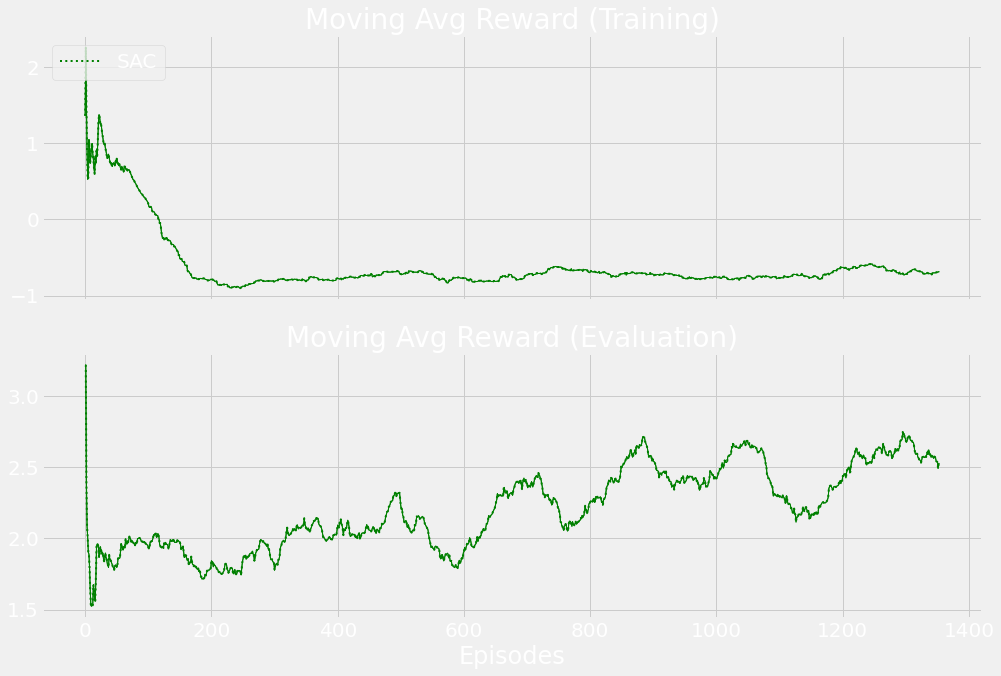

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,10), sharey=False, sharex=True)

# SAC
axs[0].plot(sac_max_r, 'g', linewidth=1)
axs[0].plot(sac_min_r, 'g', linewidth=1)
axs[0].plot(sac_mean_r, 'g:', label='SAC', linewidth=2)
axs[0].fill_between(
    sac_x, sac_min_r, sac_max_r, facecolor='g', alpha=0.3)

axs[1].plot(sac_max_s, 'g', linewidth=1)
axs[1].plot(sac_min_s, 'g', linewidth=1)
axs[1].plot(sac_mean_s, 'g:', label='SAC', linewidth=2)
axs[1].fill_between(
    sac_x, sac_min_s, sac_max_s, facecolor='g', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

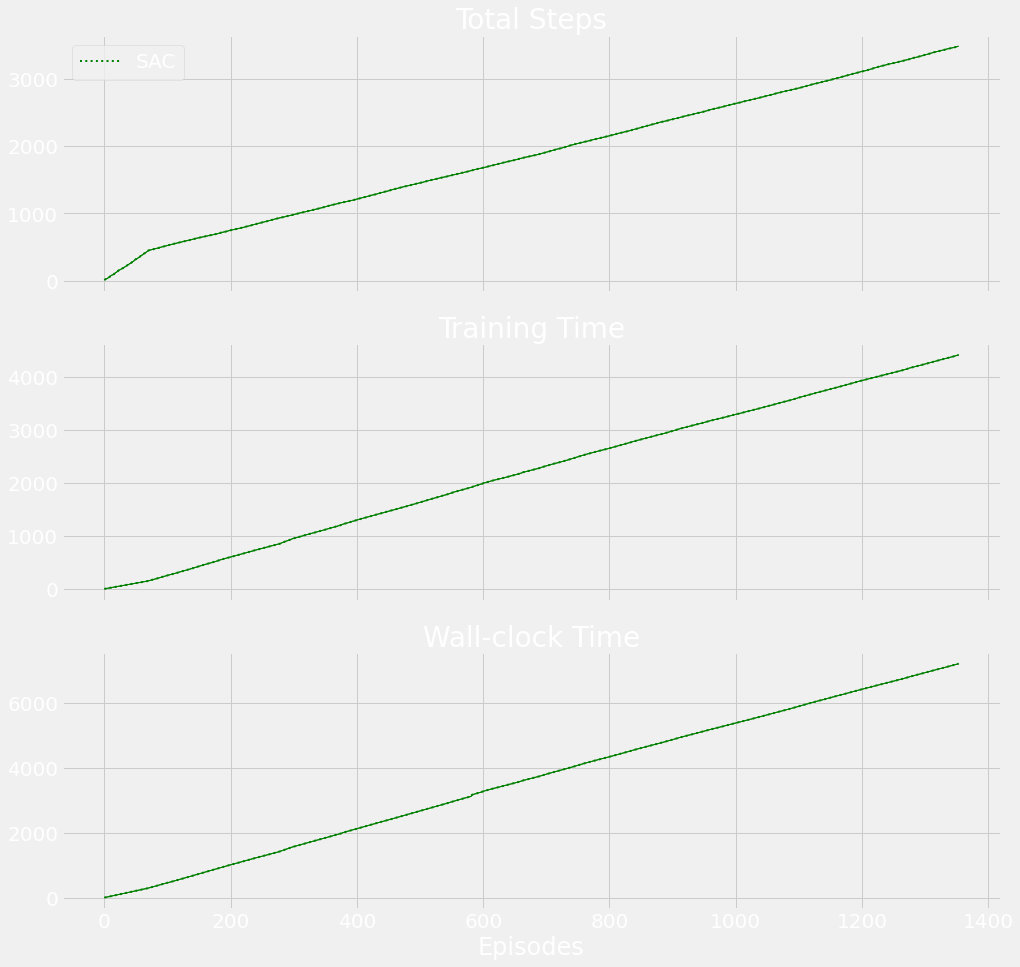

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(15,15), sharey=False, sharex=True)

# SAC
axs[0].plot(sac_max_t, 'g', linewidth=1)
axs[0].plot(sac_min_t, 'g', linewidth=1)
axs[0].plot(sac_mean_t, 'g:', label='SAC', linewidth=2)
axs[0].fill_between(
    sac_x, sac_min_t, sac_max_t, facecolor='g', alpha=0.3)

axs[1].plot(sac_max_sec, 'g', linewidth=1)
axs[1].plot(sac_min_sec, 'g', linewidth=1)
axs[1].plot(sac_mean_sec, 'g:', label='SAC', linewidth=2)
axs[1].fill_between(
    sac_x, sac_min_sec, sac_max_sec, facecolor='g', alpha=0.3)

axs[2].plot(sac_max_rt, 'g', linewidth=1)
axs[2].plot(sac_min_rt, 'g', linewidth=1)
axs[2].plot(sac_mean_rt, 'g:', label='SAC', linewidth=2)
axs[2].fill_between(
    sac_x, sac_min_rt, sac_max_rt, facecolor='g', alpha=0.3)

# ALL
axs[0].set_title('Total Steps')
axs[1].set_title('Training Time')
axs[2].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

In [ ]:
sac_root_dir = os.path.join(RESULTS_DIR, 'sac')
not os.path.exists(sac_root_dir) and os.makedirs(sac_root_dir)

np.save(os.path.join(sac_root_dir, 'x'), sac_x)

np.save(os.path.join(sac_root_dir, 'max_r'), sac_max_r)
np.save(os.path.join(sac_root_dir, 'min_r'), sac_min_r)
np.save(os.path.join(sac_root_dir, 'mean_r'), sac_mean_r)

np.save(os.path.join(sac_root_dir, 'max_s'), sac_max_s)
np.save(os.path.join(sac_root_dir, 'min_s'), sac_min_s )
np.save(os.path.join(sac_root_dir, 'mean_s'), sac_mean_s)

np.save(os.path.join(sac_root_dir, 'max_t'), sac_max_t)
np.save(os.path.join(sac_root_dir, 'min_t'), sac_min_t)
np.save(os.path.join(sac_root_dir, 'mean_t'), sac_mean_t)

np.save(os.path.join(sac_root_dir, 'max_sec'), sac_max_sec)
np.save(os.path.join(sac_root_dir, 'min_sec'), sac_min_sec)
np.save(os.path.join(sac_root_dir, 'mean_sec'), sac_mean_sec)

np.save(os.path.join(sac_root_dir, 'max_rt'), sac_max_rt)
np.save(os.path.join(sac_root_dir, 'min_rt'), sac_min_rt)
np.save(os.path.join(sac_root_dir, 'mean_rt'), sac_mean_rt)